Importing

In [94]:
# utilities
import re
import numpy as np
import pandas as pd
import string

import nltk

nltk.download('stopwords') # download stopwords
nltk.download('wordnet') #download wordnet

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords # import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

#setting up stop_words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

[nltk_data] Error loading stopwords: <urlopen error EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1129)>


In [95]:
#reading information from dataset 1
df = pd.read_excel("./LabeledText.xlsx")
df = df.drop(['File Name'], axis=1)
df.head(3)

#reading information from dataset 2
# def labelIt(num):
#     if(num==0):return "Negative"
#     elif(num==2):return "Neutral"
#     elif(num==4):return "Positive"

# DATASET_ENCODING = "ISO-8859-1"
# DATASET_COLUMNS = ["LABEL", "ids", "date", "flag", "user", "Caption"]
# df = pd.read_csv("C:/Main/Mihir/Sem 5/IE406/Project/archive/training.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
# df = df.drop(columns=['ids','date','flag','user'])
# df.LABEL = df.LABEL.apply(lambda num : labelIt(num))
# df.head(3)

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive


In [96]:
#checking out the size and labels of the dataset
print('size of the dataset:', len(df))
print('different labels:', df['LABEL'].nunique())

size of the dataset: 4869
different labels: 3


Preprocessing

In [97]:
#usnig lemmatizer in order to reduce dimension (eg. (run, running, ran) -> run)
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

#removing all the stopwords which does not have sentiment meaning (eg. and, a, the, etc.)
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

#removing all numerics
def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

#converting all the text to lower case
def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

#removing all the punctuations
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace(";","")
    text = re.sub('\\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

#removing all the urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#removing all the small sentences
def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.Caption.iloc[i].split()) < 3:
            df.Caption.iloc[i] = np.nan

#removing negation (eg. not done --> not_done)
def handle_negations(text):
    negation_words = ['not', 'no', 'never', 'none', 'nobody', 'nowhere', 'nothing', 'neither']
    words = text.split()
    modified_words = []
    is_negation = False
    for word in words:
        if word in negation_words:
            is_negation = True
        elif is_negation:
            modified_words.append('not_' + word)
            is_negation = False
        else:
            modified_words.append(word)
    processed_text = ' '.join(modified_words)
    return processed_text
            
#normalizing the text
def normalize_text(df):
    df.Caption=df.Caption.apply(lambda text : lower_case(text))
    df.Caption=df.Caption.apply(lambda text : remove_stop_words(text))
    df.Caption=df.Caption.apply(lambda text : remove_numbers(text))
    df.Caption=df.Caption.apply(lambda text : remove_punctuations(text))
    df.Caption=df.Caption.apply(lambda text : remove_urls(text))
    df.Caption=df.Caption.apply(lambda text : lemmatization(text))
    df.Caption=df.Caption.apply(lambda text : handle_negations(text))
    return df

#removing all the small sentences
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= remove_numbers(sentence)
    sentence= remove_punctuations(sentence)
    sentence= remove_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


In [98]:
#normalizing our df
df = normalize_text(df)
df

,Caption,LABEL
0,feel today legday jelly aching gym,negative
1,arrivatw absolute disgrace two carriage bangor...,negative
2,valentine s nephew elated sometimes little thi...,positive
3,betterfeelingfilms rt via instagram first day ...,neutral
4,zoe s first love rattled johnnyharper,positive
...,...,...
4864,omg well done eskom man dy loadshedding powerless,positive
4865,feelin love here valentinesday caring,positive
4866,blue eye can t beaten,neutral
4867,la chucha louuu te chupo los ojos,neutral


In [99]:
X = df.Caption
y = df.LABEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

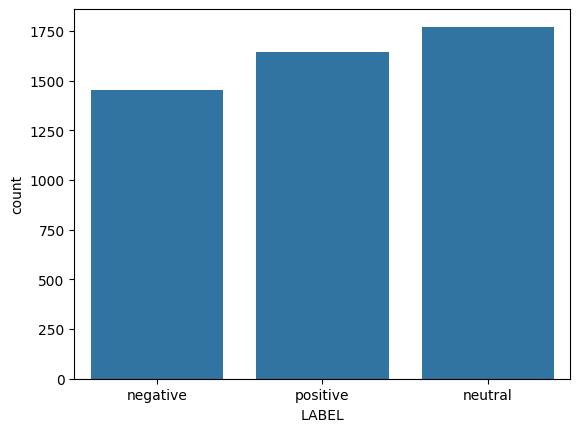

In [100]:
#See the distribution
sns.countplot(x='LABEL', data=df);

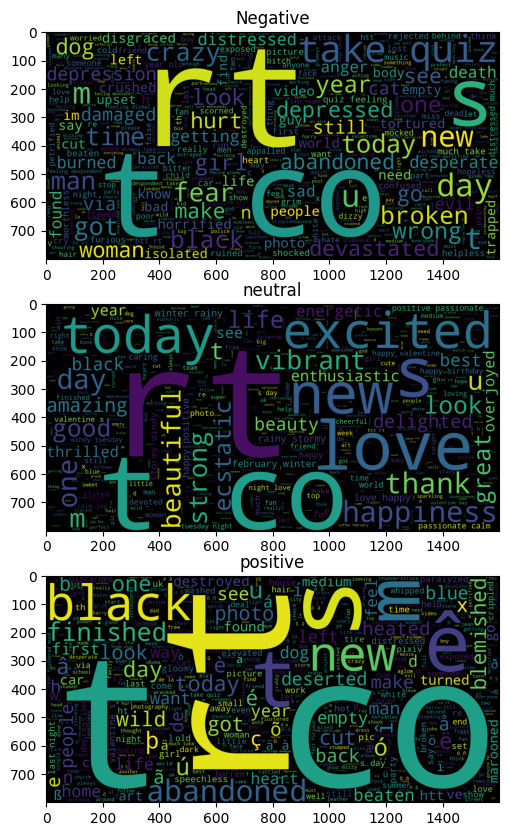

In [101]:
#separating data by their labels
df_negative = df.groupby('LABEL')['Caption'].get_group('negative')
df_neutral = df.groupby('LABEL')['Caption'].get_group('positive')
df_positive = df.groupby('LABEL')['Caption'].get_group('neutral')

#making wordclouds
wc0 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_negative))
wc1 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_neutral))
wc2 = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df_positive))

#vizualize wordclouds
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(wc0)
plt.title('Negative')
plt.subplot(3, 1, 2)
plt.imshow(wc1)
plt.title('neutral')
plt.subplot(3, 1, 3)
plt.imshow(wc2)
plt.title('positive')
plt.show()

In [102]:
def custom_tokenizer(text):
    tokens = []
    words = text.split()

    for word in words:
        emojis = [c for c in word if c in emoji.EMOJI_DATA]
        if emojis:
            tokens.extend(emojis)
        else:
            tokens.append(word)

    return tokens

#building the vectoriser
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
#use the below vectoriser if the data contains emojis
#vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=10000,tokenizer=custom_tokenizer)
#train the vectoriser
vectoriser.fit(X_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [103]:
print(X_train)
#Vectorise data
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

2167                              rt itsmovies stuck love
3189    cell phone usa blueant ribbon stereo bluetooth...
1117    along mindfulness always try honest compassion...
2211    rt supergirlcbs jovial mehcadbrooks talk thing...
4241    mm petrified wood sphere rock stone polished gram
                              ...                        
4426    rt robertwrossesq william bruce elli ranken s ...
466     flu sorethrought dizzy sickness fever medicine...
3092                   fatherandsontime http t co aqjwqva
3772    rt trendfor got vote igot fanarmyfaceoff billb...
860     meet sir button available compassionate adopti...
Name: Caption, Length: 3895, dtype: object


Training and Testing

In [104]:
#Testing with SVM
SVM = SVC(kernel = 'linear', random_state = 0)
SVM.fit(X_train, y_train)
y_pred4 = SVM.predict(X_test)
accuracy = accuracy_score(y_test, y_pred4)
print("accuracy:", accuracy)

accuracy: 0.6971252566735113


In [105]:
#Tesing with Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred5 = LRmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred5)
print("accuracy:", accuracy)

accuracy: 0.6950718685831622


In [106]:
#Testing with Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)
y_pred6 = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred6)
print("accuracy:", accuracy)




accuracy: 0.6529774127310062


In [107]:
text_samples = [
    'Feeling joyous, filled with happiness inside.',
    'Terrified, trembling in fear of the unknown.',
    'Heartbroken, lost in a sea of despair.',
    'Consumed by rage, boiling with anger.',
    "I stopped feeling cold and began feeling hotter.",
    'Surprised by events, shock coursing through.',
    'Deep relaxation, serenity envelops my being.',
    'Exhilaration runs high, excitement overflows.',
    'Boredom creeps in, a dull, listless state.',
    'Lifeless and still, devoid of sensation.',
    "Mihir's code is so bad, it makes me cry.",
    " want each of you to feel my gentle embrace",
]

predictions = SVM.predict(vectoriser.transform([normalized_sentence(text) for text in text_samples]))
data = {'Text': text_samples, 'Predicted Emotion': predictions}
df = pd.DataFrame(data)
print(df)

                                                Text Predicted Emotion
0      Feeling joyous, filled with happiness inside.          positive
1       Terrified, trembling in fear of the unknown.          negative
2             Heartbroken, lost in a sea of despair.          negative
3              Consumed by rage, boiling with anger.          negative
4   I stopped feeling cold and began feeling hotter.          negative
5       Surprised by events, shock coursing through.          positive
6       Deep relaxation, serenity envelops my being.          negative
7      Exhilaration runs high, excitement overflows.          negative
8         Boredom creeps in, a dull, listless state.           neutral
9           Lifeless and still, devoid of sensation.          negative
10          Mihir's code is so bad, it makes me cry.          negative
11        want each of you to feel my gentle embrace           neutral
